In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet', 
                  include_top = False, 
                  input_shape = (150, 150, 3))

conv_base.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

**FAST
FEATURE EXTRACTION WITHOUT DATA AUGMENTATION**

In [3]:
import os 
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

train_dir = 'cats_and_dogs_small/train'
valid_dir = 'cats_and_dogs_small/validation'
test_dir = 'cats_and_dogs_small/test'

datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 20


def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count, 4, 4, 512))
    labels = np.zeros(shape = (sample_count))
    generator = datagen.flow_from_directory(
        directory, 
        target_size = (150, 150), 
        batch_size = batch_size, 
        class_mode = 'binary')
    
    i = 0
    for input_batch, labels_batch in generator:
        features_batch = conv_base.predict(input_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [4]:
train_features, train_labels = extract_features(train_dir, 2000)
valid_features, valid_labels = extract_features(valid_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
print(train_features.shape)

(2000, 4, 4, 512)


In [6]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [7]:
model.compile(
    optimizer = optimizers.RMSprop(lr = 2e-5), 
    loss = 'binary_crossentropy', 
    metrics = ['acc'])

In [8]:
history = model.fit(train_features, 
                    train_labels, 
                    epochs = 30, 
                    batch_size = 20, 
                    validation_data = (valid_features, valid_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 488us/step - loss: 0.6148 - acc: 0.6490 - val_loss: 0.4518 - val_acc: 0.8210
Epoch 2/30
2000/2000 [==============================] - 1s 261us/step - loss: 0.4352 - acc: 0.8005 - val_loss: 0.3670 - val_acc: 0.8620
Epoch 3/30
2000/2000 [==============================] - 0s 221us/step - loss: 0.3616 - acc: 0.8450 - val_loss: 0.3261 - val_acc: 0.8680
Epoch 4/30
2000/2000 [==============================] - 0s 186us/step - loss: 0.3179 - acc: 0.8720 - val_loss: 0.3032 - val_acc: 0.8700
Epoch 5/30
2000/2000 [==============================] - 0s 181us/step - loss: 0.2891 - acc: 0.8840 - val_loss: 0.2893 - val_acc: 0.8890
Epoch 6/30
2000/2000 [==============================] - 0s 200us/step - loss: 0.2676 - acc: 0.8955 - val_loss: 0.2728 - val_acc: 0.8880
Epoch 7/30
2000/2000 [==============================] - 0s 214us/step - loss: 0.2502 - acc: 0.8985 - val_loss: 0.2640 - val_acc: 0.8890


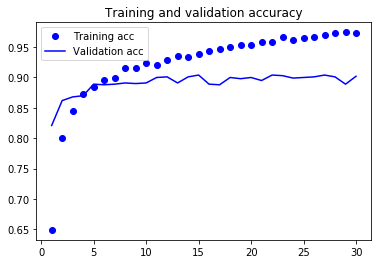

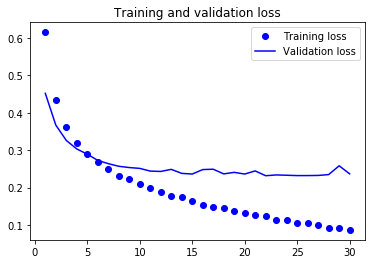

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**FEATURE EXTRACTION
WITH DATA AUGMENTATION**

In [10]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(265, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 265)               2171145   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 266       
Total params: 16,886,099
Trainable params: 16,886,099
Non-trainable params: 0
_________________________________________________________________


**Freeze conv layers**

In [11]:
print("Before freezing ", len(model.trainable_weights))

Before freezing  30


In [12]:
conv_base.trainable = False

In [13]:
print("After freezing ", len(model.trainable_weights))

After freezing  4


In [14]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150), 
    batch_size=20, 
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    valid_dir, 
    target_size=(150, 150), 
    batch_size=20, 
    class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
model.compile(
    optimizer = optimizers.RMSprop(lr = 2e-5), 
    loss = 'binary_crossentropy', 
    metrics = ['acc'])

In [16]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch = 100, 
    epochs = 30, 
    validation_data = validation_generator, 
    validation_steps = 50)

Epoch 1/30
100/100 [==============================] - 21s 207ms/step - loss: 0.5869 - acc: 0.6950 - val_loss: 0.4644 - val_acc: 0.8000
Epoch 2/30
100/100 [==============================] - 19s 194ms/step - loss: 0.4825 - acc: 0.7995 - val_loss: 0.3695 - val_acc: 0.8670
Epoch 3/30
100/100 [==============================] - 19s 190ms/step - loss: 0.4151 - acc: 0.8255 - val_loss: 0.3266 - val_acc: 0.8760
Epoch 4/30
100/100 [==============================] - 19s 191ms/step - loss: 0.3923 - acc: 0.8315 - val_loss: 0.3033 - val_acc: 0.8870
Epoch 5/30
100/100 [==============================] - 19s 191ms/step - loss: 0.3818 - acc: 0.8310 - val_loss: 0.2894 - val_acc: 0.8890
Epoch 6/30
100/100 [==============================] - 19s 192ms/step - loss: 0.3769 - acc: 0.8345 - val_loss: 0.2809 - val_acc: 0.8890
Epoch 7/30
100/100 [==============================] - 19s 191ms/step - loss: 0.3599 - acc: 0.8425 - val_loss: 0.2744 - val_acc: 0.8890
Epoch 8/30
100/100 [==============================] - 1

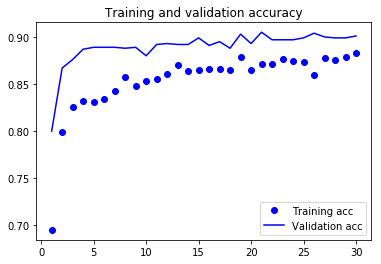

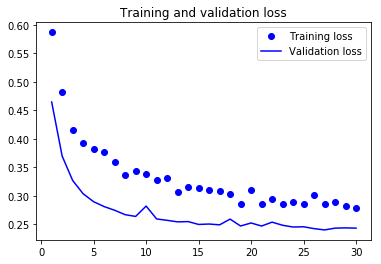

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**Fine-tuning**

In [18]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [19]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [20]:
model.compile(loss = 'binary_crossentropy', 
              optimizer = optimizers.RMSprop(lr = 1e-5), 
              metrics = ['acc'])

In [ ]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch = 100, 
    epochs = 30, 
    validation_data = validation_generator, 
    validation_steps = 50)

Epoch 1/30


In [1]:
test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(150, 150), 
    batch_size=20, 
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

NameError: name 'test_datagen' is not defined